# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: Cross-validation for regularization
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [3]:
# import the data

matfile = sio.loadmat('MATLAB_data_files/sampleEEGdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data'])

In [4]:
## get covariance matrices

# filter data in alpha
centerFreq = 11
freqFWHM = 4

fdata = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],centerFreq,freqFWHM)[0]



# covariance matrices
covR = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )
covS = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )

for ti in range(EEG['trials'][0][0]):
    
    # covariance of broadband
    tmp = scipy.signal.detrend(EEG['data'][:,:,ti])
    covR += tmp@tmp.T / EEG['pnts'][0][0]
    
    # covariance of filtered data
    tmp = scipy.signal.detrend(fdata[:,:,ti])
    covS += tmp@tmp.T / EEG['pnts'][0][0]
    
# average covariances by dividing by trials
covR = covR/ti
covS = covS/ti

In [14]:
## cross-validation

# range of gamma parameter values
gammas = np.linspace(0,.5,43)

# initialize matrices
maxLambdas = np.zeros(len(gammas))
comptsRMS  = np.zeros(len(gammas))
reguEigRat = np.zeros(len(gammas))


# loop over gamma values
for gi in range(len(gammas)):
    
    # regularize
    g = gammas[gi]
    R = (1-g)*covR + g*np.mean(np.linalg.eig(covR)[0])*np.eye(EEG['nbchan'][0][0])
    
    # GED and sorting index
    evals,evecs = scipy.linalg.eigh(covS,R)
    sidx = np.argsort(evals)[::-1]
    
    # component time series
    comp_tsB = evecs[:,sidx[0]].T @ np.reshape(EEG['data'],(64,-1),order='F')
    comp_tsF = evecs[:,sidx[0]].T @ np.reshape(fdata,(64,-1),order='F')
    
    # store max eigenvalue and component energy
    maxLambdas[gi] = np.max(np.abs(evals))
    comptsRMS[gi]  = np.sqrt(np.mean(comp_tsF**2)) / np.sqrt(np.mean(comp_tsB**2))
    Revals = np.linalg.eig(R)[0]
    reguEigRat[gi] = np.max(np.abs(Revals)) / np.min(np.abs(Revals))

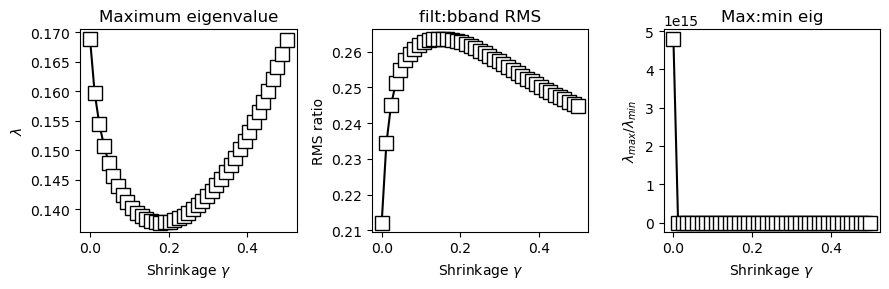

In [15]:
## plot the xval results

_,axs = plt.subplots(1,3,figsize=(9,3))

axs[0].plot(gammas,maxLambdas,'ks-',markerfacecolor='w',markersize=10)
axs[0].set_xlabel('Shrinkage $\gamma$')
axs[0].set_ylabel('$\lambda$')
axs[0].set_title('Maximum eigenvalue')

axs[1].plot(gammas,comptsRMS,'ks-',markerfacecolor='w',markersize=10)
axs[1].set_xlabel('Shrinkage $\gamma$')
axs[1].set_ylabel('RMS ratio')
axs[1].set_title('filt:bband RMS')

axs[2].plot(gammas,reguEigRat,'ks-',markerfacecolor='w',markersize=10)
axs[2].set_xlabel('Shrinkage $\gamma$')
axs[2].set_ylabel('$\lambda_{max}/\lambda_{min}$')
axs[2].set_title('Max:min eig')


plt.tight_layout()
plt.show()

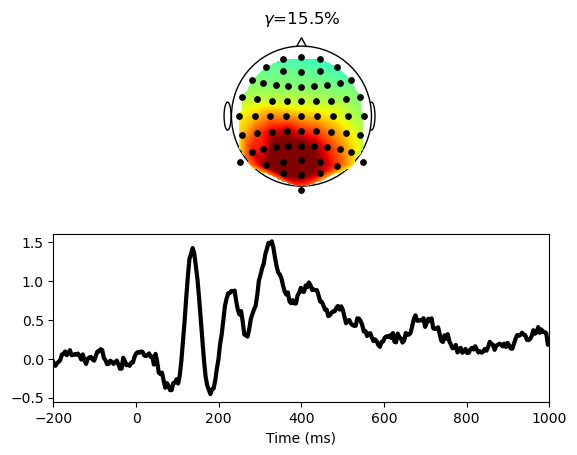

In [16]:
## apply the "best" regularization parameter

# get the best parameter
bestGammaLoc = np.argmax(comptsRMS)

regu_gam = gammas[bestGammaLoc]


# apply the regularization
Rregu = (1-regu_gam)*covR + regu_gam*np.mean(np.linalg.eig(covR)[0])*np.eye(EEG['nbchan'][0][0])



### GED etc
evals,evecs = scipy.linalg.eigh(covS,Rregu)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]

# component time series
tmpts = evecs[:,0].T @ np.reshape(EEG['data'],(EEG['nbchan'][0][0],-1),order='F')
ts = np.reshape( tmpts,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F' )
             
# topomaps and time series
topo = evecs[:,0].T@covS
mv = np.argmax(np.abs(topo))
if topo[mv]<0:
    topo = -topo
    ts = -ts
    


# topoplot of component map
_,axs = plt.subplots(2,1)
topoplotIndie(topo,EEG['chanlocs'],f'$\gamma$={100*regu_gam:.1f}%',axs[0])

# ERP
axs[1].plot(EEG['times'],np.mean(ts,axis=1),'k',linewidth=3)
axs[1].set_xlim([-200, 1000])
axs[1].set_xlabel('Time (ms)')
plt.show()